In [239]:
# Import library yang ingin digunakan

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import transforms
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [240]:
print(torch.__version__)

2.3.0+cpu


In [241]:
# Path data yg dipakai
training_dataset_path = './train_images/'
testing_dataset_path = './test_images/'

# Fungsi untuk cek folder, memastikan class yang digunakan sesuai
def cek_folder(path):
    # List direktori
    files = os.listdir(path)

    # Cek foldernya saja
    filtered_files = [file for file in files if not file.endswith(('.png', '.jpg'))]

    print("Folder direktori class.. ", filtered_files)
cek_folder(training_dataset_path)
cek_folder(testing_dataset_path)

Folder direktori class..  ['melanoma', 'not_melanoma']
Folder direktori class..  []


In [242]:
# Fungsi untuk load data dan melakukan normalize
def load_and_normalize(path, batch_size=32, sampler=None):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = ImageFolder(root=path, transform=transform)
    print("Berhasil memuat dataset..")
    print("Indeks kelas: " + str(dataset.class_to_idx))

    if sampler is not None:
        print("sampler")
        loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        print("no sampler")
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    print("Berhasil membuat data loader..")
    return loader

# Me-split dataset menjadi data training dan validation
dataset = ImageFolder(root=training_dataset_path, transform=transforms.ToTensor())
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

train_split = int(0.8 * dataset_size)
train_indices = indices[:train_split]
val_indices = indices[train_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Load training and validation data
train_loader = load_and_normalize(training_dataset_path, sampler=None)
val_loader = load_and_normalize(training_dataset_path, sampler=None)

Berhasil memuat dataset..
Indeks kelas: {'melanoma': 0, 'not_melanoma': 1}
no sampler
Berhasil membuat data loader..
Berhasil memuat dataset..
Indeks kelas: {'melanoma': 0, 'not_melanoma': 1}
no sampler
Berhasil membuat data loader..


In [243]:
# Menggunakan custom dataset untuk data testing
# Perbedaan dengan data training: data testing tidak memiliki label kelas sendiri

class CustomTestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.image_files = [file for file in os.listdir(path) if file.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.path, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Ensure 3 channels (RGB)
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [244]:
# Mendefinisikan transformasi yang dilakukan pada data testing
# Perhatikan bahwa data testing juga dilakukan preprocessing tapi tanpa augmentasi yang dapat mengubah gambar secara signifikan, karena tujuannya adalah evaluasi model.

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = CustomTestDataset(path='./test_images/', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(test_loader)

In [245]:
# Mengecek ukuran gambar

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


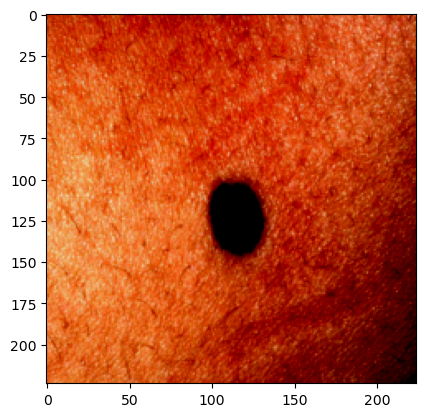

In [246]:
# Melihat sekilas dataset

# Konversi tensor ke numpy array, lalu transpose dimensinya
image = images[1].numpy().transpose((1, 2, 0))

plt.imshow(image)
plt.show()

In [247]:
# Mendefinisikan arsitektur convolutional neural network sederhana
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.5) 
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 56 * 56, 10),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


In [248]:
# Model yang digunakan
model = Net()

# Optimizer: pakai Adam
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Loss function: pakai Cross Entropy
criterion = nn.CrossEntropyLoss()

# Scheduler untuk menurunkan learning rate jika tidak ada perbaikan pada validation loss
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)


C:\Users\afiqi\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [249]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [250]:
# Menentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

Epoch 1 - Training loss: 1.2745 - Validation loss: 1.6164
Epoch 2 - Training loss: 0.6829 - Validation loss: 1.0572
Epoch 3 - Training loss: 0.6256 - Validation loss: 0.7797
Epoch 4 - Training loss: 0.6401 - Validation loss: 0.6764
Epoch 5 - Training loss: 0.6429 - Validation loss: 0.6266
Epoch 6 - Training loss: 0.5845 - Validation loss: 0.5835
Epoch 7 - Training loss: 0.6121 - Validation loss: 0.5569
Epoch 8 - Training loss: 0.5492 - Validation loss: 0.5397
Epoch 9 - Training loss: 0.5897 - Validation loss: 0.5330
Epoch 10 - Training loss: 0.5410 - Validation loss: 0.5315
Epoch 11 - Training loss: 0.5582 - Validation loss: 0.5258
Epoch 12 - Training loss: 0.5639 - Validation loss: 0.5101
Epoch 13 - Training loss: 0.5353 - Validation loss: 0.5053
Epoch 14 - Training loss: 0.5330 - Validation loss: 0.4879
Epoch 15 - Training loss: 0.5308 - Validation loss: 0.4907
Epoch 16 - Training loss: 0.4955 - Validation loss: 0.4838
Epoch 17 - Training loss: 0.5406 - Validation loss: 0.4706
Epoch 

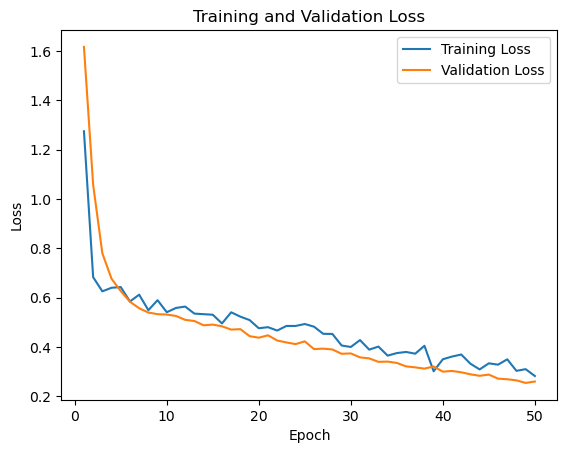

In [251]:
import matplotlib.pyplot as plt

# Menyimpan nilai loss untuk setiap epoch
train_losses = []
val_losses = []

# Training loop
num_epochs = 50
early_stopping = EarlyStopping(patience=7, min_delta=0.001)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item() * data.size(0)

    val_loss /= len(val_loader.dataset)

    # Menyimpan nilai loss untuk setiap epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1} - Training loss: {train_loss:.4f} - Validation loss: {val_loss:.4f}')

    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Membuat plot
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [252]:
# Evaluasi: mendapatkan nilai akurasi dan f1-score

from sklearn.metrics import f1_score

correct_count, all_count = 0, 0
all_labels = []
all_predictions = []

model.eval()

for images, labels in train_loader: 
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        
    with torch.no_grad():
        outputs = model(images)
        
    _, predicted = torch.max(outputs, 1)
    all_count += labels.size(0)
    correct_count += (predicted == labels).sum().item()
    
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

accuracy = correct_count / all_count
f1 = f1_score(all_labels, all_predictions, average='binary')

print("\nAccuracy =", accuracy)
print("\nF1-score =", f1)

model.train()


Accuracy = 0.9257142857142857

F1-score = 0.9103448275862069


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [253]:
# KLasifikasi pada data testing
correct_count, all_count = 0, 0
model.eval()
dummy_labels = ['Not Melanoma', 'Melanoma']

predictions = []

for images, image_files in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        
    with torch.no_grad():
        outputs = model(images)
        
    _, predicted = torch.max(outputs, 1)
    predicted_labels = [dummy_labels[p] for p in predicted.cpu().numpy()]
    
    for img_file, label in zip(image_files, predicted_labels):
        predictions.append((img_file, label))

for img_file, label in predictions:
    print(f"Image: {img_file}, Predicted Label: {label}")

model.train()

Image: data_102_orig.jpg, Predicted Label: Not Melanoma
Image: data_106_orig.jpg, Predicted Label: Not Melanoma
Image: data_11_orig.jpg, Predicted Label: Melanoma
Image: data_130_orig.jpg, Predicted Label: Melanoma
Image: data_131_orig.jpg, Predicted Label: Not Melanoma
Image: data_135_orig.jpg, Predicted Label: Melanoma
Image: data_151_orig.jpg, Predicted Label: Not Melanoma
Image: data_160_orig.jpg, Predicted Label: Melanoma
Image: data_171_orig.jpg, Predicted Label: Not Melanoma
Image: data_176_orig.jpg, Predicted Label: Not Melanoma
Image: data_177_orig.jpg, Predicted Label: Melanoma
Image: data_17_orig.jpg, Predicted Label: Melanoma
Image: data_180_orig.jpg, Predicted Label: Melanoma
Image: data_183_orig.jpg, Predicted Label: Not Melanoma
Image: data_189_orig.jpg, Predicted Label: Melanoma
Image: data_191_orig.jpg, Predicted Label: Not Melanoma
Image: data_200_orig.jpg, Predicted Label: Not Melanoma
Image: data_24_orig.jpg, Predicted Label: Not Melanoma
Image: data_33_orig.jpg, Pr

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12544, out_features=10, bias=True)
  )
)

In [254]:
# Simpan ke csv untuk Kaggle

def generate_predictions_csv(model, test_loader, output_file='submission.csv'):
    model.eval() 

    predictions = []
    image_ids = []

    dummy_labels = ['Not Melanoma', 'Melanoma']

    with torch.no_grad():
        for idx, (images, image_files) in enumerate(test_loader):
            if torch.cuda.is_available():
                images = images.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = [dummy_labels[p] for p in predicted.cpu().numpy()]

            count = 0 
            for img_file, label in zip(image_files, predicted_labels):
                image_ids.append(count)  # Use image filename as ID
                predictions.append(label)
                count += 1

    df = pd.DataFrame({'id': image_ids, 'class': predictions})

    df.to_csv(output_file, index=False)
    print(f"Berhasil menyimpan ke {output_file}")

generate_predictions_csv(model, test_loader)

Berhasil menyimpan ke submission.csv


In [255]:
# Menyimpan model dalam format pth

torch.save(model, 'model.pth')